In [1]:
import seaborn as sbn
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import pysam
import numpy as np

# Define functions

In [2]:
def parseDirectory(path):
    """Looks for sequencing files in input directory
    and opens them."""
    files = os.listdir(path)
    filesFilt = [x for x in files if "bam" in x]
    if len(filesFilt) == 0:
        filesFilt = [x for x in files if "sam" in x]
        if len(filesFilt) == 0:
            raise ValueError("No suitable file fount in the hicup directory!")
    filePaths = {i[0:6]: os.path.join(path, i) for i in filesFilt}
    return filePaths

def countMutationsPerRead(alignment, mappingq=40, readqual=27, posQual=30, norm=True, reads=100000):
    output = []
    for index, readInst in enumerate(alignment):
        MutDict = {"AC": 0.0, "AG": 0.0, "AT": 0.0, "CA": 0.0, "CG": 0.0,
            "CT": 0.0, "GA": 0.0, "GC": 0.0, "GT": 0.0, "TA": 0.0, "TC": 0.0, "TG": 0.0}
        BaseNumb = {"A": 0.0, "C": 0.0, "T": 0.0, "G": 0.0}
        if index % 10000 == 0:
            print("%s reads processed" % (index))
        if index > reads:
            break
        if readInst.mapping_quality < mappingq:
            continue
        if np.mean(readInst.query_qualities) < readqual:
            continue
        mutationCount, baseCount = getMutationlist(readInst, qual=posQual)
        for pointMut in MutDict.keys():
            MutDict[pointMut] += mutationCount.count(pointMut)
        output.append(MutDict)
    return output


def countMutations(alignment, mappingq=40, readqual=27, posQual=30, norm=True, reads=100000):
    MutDict = {"AC": 0.0, "AG": 0.0, "AT": 0.0, "CA": 0.0, "CG": 0.0,
               "CT": 0.0, "GA": 0.0, "GC": 0.0, "GT": 0.0, "TA": 0.0, "TC": 0.0, "TG": 0.0}
    BaseNumb = {"A": 0.0, "C": 0.0, "T": 0.0, "G": 0.0}
    for index, readInst in enumerate(alignment):
        if index % 10000 == 0:
            print("%s reads processed" % (index))
        if index > reads:
            break
        if readInst.mapping_quality < mappingq:
            continue
        if np.mean(readInst.query_qualities) < readqual:
            continue
        mutationCount, baseCount = getMutationlist(readInst, qual=posQual)
        for pointMut in MutDict.keys():
            MutDict[pointMut] += mutationCount.count(pointMut)
        for base in BaseNumb.keys():
            BaseNumb[base] += baseCount.get(base, 0)
    if norm:
        for pointMut in MutDict.keys():
            base = pointMut[0]
            MutDict[pointMut] = MutDict[pointMut]/BaseNumb[base]
    return MutDict


def getMutationlist(alignedSegment, qual=30):
    """Uses methods of pysam.AlignedSegment to get all pointmutations.
    Stores them as strings in self.MutationList.
    (e.g. AG corresponds to A mutated to G)"""
    pairs = alignedSegment.get_aligned_pairs(matches_only=False, with_seq=True)
    ref = np.array(
        [x[2].upper() if x[2] is not None else None for x in pairs])
    read = [x[0] for x in pairs]
    query = alignedSegment.query_sequence
    readBase = np.array(
        [query[x] if x is not None else None for x in read])
    readQuality = np.array(
        [alignedSegment.query_qualities[x] if x is not None else None for x in read])
    ind = ref == readBase
    final = []
    count = []
    for x, check in enumerate(ind):
        if not check and ((ref[x] is not None) and (readBase[x] is not None)):
            if readQuality[x] >= qual:
                final.append(ref[x] + readBase[x])
                count.append(ref[x])
        if ((ref[x] is not None) and (readBase[x] is not None)):
            if readQuality[x] >= qual:
                count.append(ref[x])
    return (final, Counter(count))


def mapBarcodes(filePaths, barcodefile, sep=","):
    """Takes in a comma seperated file containing Name and Sequence columns
    denoting a sample name under Name and the barcode sequence
    under Sequence. Will discard barcodes that are not in the barcodeFile.
    """
    output = {}
    barcodes = pd.read_csv(barcodefile, sep=sep)
    mapping = barcodes[["Name", "Sequence"]]
    for barcode in set(mapping["Sequence"]):
        newkey = mapping.loc[mapping.Sequence == barcode, "Name"]\
            .values[0]
        output[newkey] = filePaths[barcode]
    return output


def normalizeToControl(mutationDict, controlBar):
    """Sets the mutationrates stored in mutationDict as fold
    control.
    The control sample is defined through the controlBar parameter."""
    normDict = {}
    for barcode in mutationDict.keys():
        normDict[barcode] = {}
        for mut in set(mutationDict[barcode].keys()):
            if mutationDict[controlBar][mut] == 0:
                normDict[barcode][mut] = 0
            else:
                normDict[barcode][mut] = mutationDict[barcode][mut] / \
                    mutationDict[controlBar][mut]
    return normDict


def AnnotateMut(x):
    if x["mut"] in ["TC", "AG"]:
        return "4sT"
    return "Background"


# Calculate mutations per read for the different replicates

In [3]:
os.chdir("/groups/gerlich/experiments/Experiments_004500/"
         "004594/Sequencing_data/")

In [4]:
files = parseDirectory("./")

In [5]:
mapped = mapBarcodes(
    files, "/groups/gerlich/experiments/Experiments_004500/004574/Sample_mapping_exp4574.csv")

In [6]:
mutationStats = {}

for barcode, fileP in mapped.items():
    mutationStats[barcode] = {}
    with pysam.AlignmentFile(fileP, "rb") as samfile:
        mutationStats[barcode] = countMutationsPerRead(samfile, reads=50000, mappingq=38,
                                                readqual=30, posQual=30, norm=False)

0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
0 reads processed
10000 reads processed
20000 reads processed
30000 reads processed
40000 reads processed
50000 reads processed


In [7]:
labelled = {}
for i in range(1,4):
    labelled[f"rep {i}"] = pd.DataFrame(mutationStats[f"4sT new NH4Cl {i}"])
control = pd.DataFrame(mutationStats["Control new NH4Cl"])

In [8]:
for i in range(1, 4):
    if i == 1:
        labbin, labx = np.histogram(labelled[f"rep {i}"]["TC"], density=True, bins=range(6))
    else:
        labbinTemp, labxTemp = np.histogram(labelled[f"rep {i}"]["TC"], density=True, bins=range(6))
        labbin += labbinTemp
labbin = labbin/3
controlbin, controlx = np.histogram(control["TC"], density=True, bins=range(6))

In [9]:
for i in range(1, 4):
    if i == 1:
        labbinAG, labxAG = np.histogram(labelled[f"rep {i}"]["AG"], density=True, bins=range(6))
    else:
        labbinTempAG, labxTempAG = np.histogram(labelled[f"rep {i}"]["AG"], density=True, bins=range(6))
        labbinAG += labbinTempAG
labbinAG = labbinAG/3
controlbinAG, controlxAG = np.histogram(control["AG"], density=True, bins=range(6))

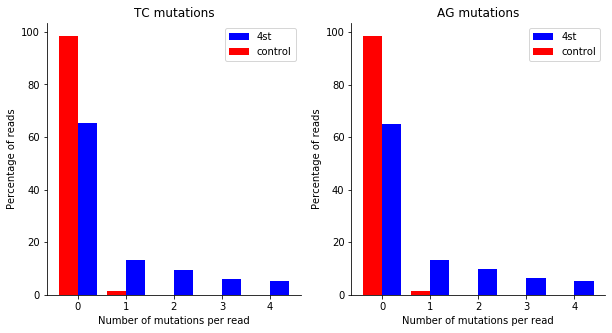

In [10]:
f, ax = plt.subplots(1, 2)
ax[0].bar(labx[:-1] + 0.2, labbin * 100, label="4st", color="blue", width=0.4)
ax[0].bar(controlx[:-1] - 0.2, controlbin * 100, label="control", color="red", width=0.4)
ax[1].bar(labxAG[:-1] + 0.2, labbinAG * 100, label="4st", color="blue", width=0.4)
ax[1].bar(controlxAG[:-1] - 0.2, controlbinAG * 100, label="control", color="red", width=0.4)
ax[0].set(title="TC mutations", xlabel="Number of mutations per read", ylabel="Percentage of reads")
ax[1].set(title="AG mutations", xlabel="Number of mutations per read", ylabel="Percentage of reads")
sbn.despine()
ax[0].legend()
ax[1].legend()
f.set_size_inches(10, 5)
plt.show()

# Make plot that is average of both signature mutation types

In [11]:
labbinAv = (labbin + labbinAG)/2
controlbinAv = (controlbin + controlbinAG)/2

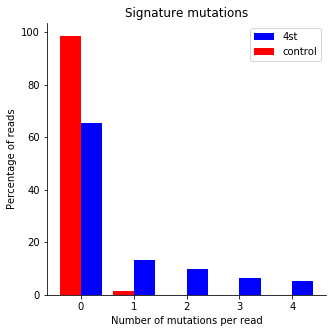

In [12]:
f, ax = plt.subplots()
ax.bar(labx[:-1] + 0.2, labbinAv * 100, label="4st", color="blue", width=0.4)
ax.bar(controlx[:-1] - 0.2, controlbinAv * 100, label="control", color="red", width=0.4)
ax.set(title="Signature mutations", xlabel="Number of mutations per read", ylabel="Percentage of reads")
sbn.despine()
ax.legend()
f.set_size_inches(5, 5)
plt.show()

## save to file

In [13]:
import matplotlib
matplotlib.rcParams.update({"pdf.fonttype": 42})
resultsdir = "/groups/gerlich/experiments/Experiments_004700/004765"
f.savefig(os.path.join(resultsdir, "Distribution_read_mutations.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Distribution_read_mutations.pdf"), bbox_inches="tight")